<a href="https://colab.research.google.com/github/PrashantBagri/Car-rental-service-nextjs/blob/main/20260202_ANNDigitalWeights_PB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



In [24]:
LEVELS = tf.constant([0.0, 0.25, 0.75, 1.0], dtype=tf.float32)


In [25]:
def quantize_to_levels(x):
    x = tf.clip_by_value(x, 0.0, 1.0)
    diffs = tf.abs(x[..., tf.newaxis] - LEVELS)   # (..., 4)
    idx = tf.argmin(diffs, axis=-1)
    return tf.gather(LEVELS, idx)


In [26]:
def ste(x, qx):
    return x + tf.stop_gradient(qx - x)

def ste_sign(x):
    s = tf.where(x >= 0.0, 1.0, -1.0)
    return ste(x, tf.cast(s, x.dtype))


In [27]:
class DigitalDense(layers.Layer):
    """
    Effective weight = sign * magnitude
    magnitude in {0, 0.25, 0.75, 1}
    sign in {-1, +1}
    """
    def __init__(self, units, use_bias=True, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.use_bias = use_bias

    def build(self, input_shape):
        in_dim = int(input_shape[-1])

        self.w_mag = self.add_weight(
            shape=(in_dim, self.units),
            initializer=keras.initializers.RandomUniform(0.0, 1.0),
            trainable=True,
            name="w_mag"
        )

        self.w_sign = self.add_weight(
            shape=(in_dim, self.units),
            initializer=keras.initializers.RandomNormal(stddev=0.05),
            trainable=True,
            name="w_sign"
        )

        self.b = None
        if self.use_bias:
            self.b = self.add_weight(
                shape=(self.units,),
                initializer="zeros",
                trainable=True,
                name="bias"
            )

    def call(self, x):
        mag_q  = ste(self.w_mag, quantize_to_levels(self.w_mag))
        sign_q = ste_sign(self.w_sign)
        w_eff = sign_q * mag_q

        y = tf.matmul(x, w_eff)
        if self.b is not None:
            y = y + self.b
        return y


In [28]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()


In [29]:
x_train = (x_train.astype("float32") / 255.0).reshape(-1, 784)
x_test  = (x_test.astype("float32") / 255.0).reshape(-1, 784)


In [30]:
inputs = keras.Input(shape=(784,))

x = DigitalDense(512)(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = DigitalDense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = DigitalDense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = DigitalDense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

outputs = DigitalDense(10)(x)
model = keras.Model(inputs, outputs)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ digital_dense_8 (DigitalDense)  │ (None, 512)            │       803,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ digital_dense_9 (DigitalDense)  │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ digital_dense_10 (DigitalDense) │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ digital_dense_11 (DigitalDense) │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ digital_dense_12 (DigitalDense) │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,152,970 (4.40 MB)

 Trainable params: 1,151,050 (4.39 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [31]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)


In [32]:
history = model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=5,
    validation_split=0.1,
    verbose=2
)


Epoch 1/5
422/422 - 26s - 62ms/step - accuracy: 0.9123 - loss: 0.3056 - val_accuracy: 0.9535 - val_loss: 0.1550
Epoch 2/5
422/422 - 21s - 50ms/step - accuracy: 0.9614 - loss: 0.1231 - val_accuracy: 0.9703 - val_loss: 0.1084
Epoch 3/5
422/422 - 22s - 52ms/step - accuracy: 0.9701 - loss: 0.0934 - val_accuracy: 0.9700 - val_loss: 0.1121
Epoch 4/5
422/422 - 41s - 97ms/step - accuracy: 0.9751 - loss: 0.0779 - val_accuracy: 0.9735 - val_loss: 0.0908
Epoch 5/5
422/422 - 20s - 47ms/step - accuracy: 0.9793 - loss: 0.0652 - val_accuracy: 0.9700 - val_loss: 0.1022


In [33]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy:", float(test_acc))


Test accuracy: 0.9674000144004822


In [34]:
_ = model(tf.zeros([1, 784], dtype=tf.float32))  # ensures built



In [35]:
for layer in model.layers:
    if isinstance(layer, DigitalDense):
        print("Layer:", layer.name, "built:", layer.built)
        print("Has w_mag:", hasattr(layer, "w_mag"), "Has w_sign:", hasattr(layer, "w_sign"))
        break


Layer: digital_dense_8 built: True
Has w_mag: True Has w_sign: True


In [36]:
for layer in model.layers:
    if isinstance(layer, DigitalDense):
        mag_q = quantize_to_levels(layer.w_mag)
        sign_q = tf.where(layer.w_sign >= 0.0, 1.0, -1.0)

        uniq_mag = tf.sort(tf.unique(tf.reshape(mag_q, [-1]))[0])
        uniq_sign = tf.sort(tf.unique(tf.reshape(tf.cast(sign_q, tf.float32), [-1]))[0])

        w_eff = tf.cast(sign_q, tf.float32) * mag_q
        uniq_eff = tf.sort(tf.unique(tf.reshape(w_eff, [-1]))[0])

        print("Unique magnitudes:", uniq_mag.numpy())
        print("Unique signs:", uniq_sign.numpy())
        print("Unique effective weights:", uniq_eff.numpy())
        break


Unique magnitudes: [0.   0.25 0.75 1.  ]
Unique signs: [-1.  1.]
Unique effective weights: [-1.   -0.75 -0.25 -0.    0.25  0.75  1.  ]


In [37]:
import numpy as np

NUM_SAMPLES = 10
idx = np.random.choice(len(x_test), NUM_SAMPLES, replace=False)

logits = model(x_test[idx], training=False)
probs = tf.nn.softmax(logits, axis=-1)

pred_labels = tf.argmax(probs, axis=1).numpy()
true_labels = y_test[idx]


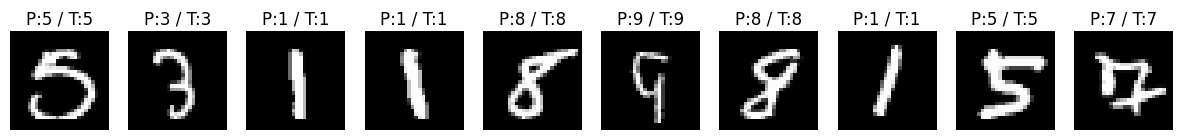

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))

for i in range(NUM_SAMPLES):
    plt.subplot(1, NUM_SAMPLES, i + 1)
    plt.imshow(x_test[idx[i]].reshape(28, 28), cmap="gray")
    plt.axis("off")
    plt.title(f"P:{pred_labels[i]} / T:{true_labels[i]}")

plt.show()


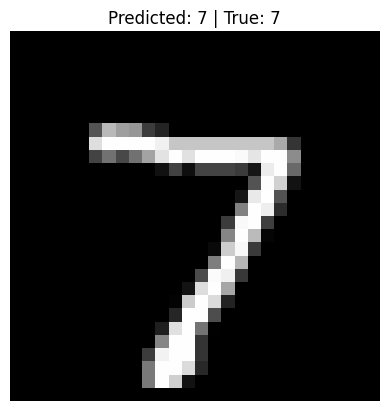

Class probabilities:
 0: 0.0000
 1: 0.0000
 2: 0.0000
 3: 0.0001
 4: 0.0000
 5: 0.0000
 6: 0.0000
 7: 0.9997
 8: 0.0000
 9: 0.0002


In [41]:
TEST_INDEX = 0   # any index from 0 to len(x_test)-1

# Get sample
image = x_test[TEST_INDEX]
true_label = y_test[TEST_INDEX]

# Predict
logits = model(tf.expand_dims(image, axis=0), training=False)
probs = tf.nn.softmax(logits, axis=-1)[0]
pred_label = tf.argmax(probs).numpy()

# Show image
plt.imshow(image.reshape(28, 28), cmap="gray")
plt.axis("off")
plt.title(f"Predicted: {pred_label} | True: {true_label}")
plt.show()

# Show probabilities
print("Class probabilities:")
for i, p in enumerate(probs.numpy()):
    print(f" {i}: {p:.4f}")